# Incremental Ernollment Trial
---------

노트북 마지막 버전.

코드가 길어져서 코어부분만 script로 옮겼다.

Visualization만 남기고 다 보내버리는 것이 나을 것 같다.

## Environment

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/pytorch-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sys.path.append('/host/projects/sv_experiments/sv_system')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def key2df(keys, delimeter="-"):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split(delimeter)[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    key_df = key_df.set_index('key')
    
    return key_df

In [4]:
fig_dir_name = './figs/'

## Dataframes & embeddings

In [5]:
# code for loading a lda embeddings from kaldi output

#import kaldi_io
#
#sv_keys = []
#sv_embeds = []
#for k,v in kaldi_io.read_vec_flt_ark("voxc2_fbank64_embeds/lda_feats.ark"):
#    sv_keys += [k]
#    sv_embeds += [v]
#
#keys = np.array(sv_keys)
#embeds = np.array(sv_embeds)
#embeds = embeds / np.linalg.norm(embeds, axis=1, keepdims=True)

In [6]:
# # dataframe for test embeds
# test_df = pd.read_pickle("/dataset/SV_sets/voxceleb12/dataframes/voxc12_sv_test_dataframe.pkl")
# test_spks = test_df.spk.unique().tolist()
# test_key_df = key_df[key_df.spk.isin(test_spks)]
# test_key_df['key'] = test_key_df.index
# test_key_df["embed_id"] =  test_key_df.key.apply(lambda x: key2index[x])

In [7]:
keys = pickle.load(open("./voxc2_fbank64_embeds/sv_keys.pkl", "rb"))
keys = np.array(keys)

# it used for mapping from key to index
key_df = key2df(keys)
key2id = {k:v for v, k in enumerate(keys)}

In [8]:
# val_df = pd.read_pickle("cases/enr6_pos300/validation/val_thresh_trials.pkl")
# val_spks = list(set(val_df.enroll_spk) | set(val_df.test_spk))
# trial_for_thresh_pos300 = trial_for_thresh[trial_for_thresh.enroll_spk.isin(val_spks) | trial_for_thresh.test_spk.isin(val_spks)]

In [9]:
# key_df for test embeds
test_key_df = pd.read_pickle("/dataset/SV_sets/voxceleb12/dataframes/voxc2_trials/voxc2_test_40_spks.pkl")

In [10]:
embeds_800f = np.load("./voxc2_fbank64_embeds/sv_embeds.npy")
# embeds_800f = embeds_800f / np.linalg.norm(embeds_800f, axis=1, keepdims=True)

In [11]:
embeds_400f = np.load("./voxc2_fbank64_embeds/400f_sub_utter/sv_embeds.npy")
# embeds_400f = embeds_400f / np.linalg.norm(embeds_400f, axis=1, keepdims=True)

In [12]:
embeds_precise = np.load("./voxc2_fbank64_precise_embeds/sv_embeds.npy")
# embeds_precise = embeds_precise / np.linalg.norm(embeds_precise, axis=1, keepdims=True)

In [13]:
embeds_untied_precise = np.load("./voxc2_fbank64_precise_untied_embeds/sv_embeds.npy")
# embeds_precise = embeds_precise / np.linalg.norm(embeds_precise, axis=1, keepdims=True)

In [14]:
enroll = 'untiedPrecise'
test = 'untiedPrecise'

if enroll == '800f':
    enroll_embeds = embeds_800f
elif enroll == '400f':
    enroll_embeds = embeds_400f[:,0]
elif enroll == 'precies':
    enroll_embeds = embeds_precise
elif enroll == 'untiedPrecise':
    enroll_embeds = embeds_untied_precise

if test == '800f':
    test_embeds = embeds_800f
elif test == '400f':
    test_embeds = embeds_400f[:,0]
elif test == 'precies':
    test_embeds = embeds_precise
elif test == 'untiedPrecise':
    test_embeds = embeds_untied_precise


## Utils

In [15]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [16]:
import torch
from torch.nn.functional import cosine_similarity
from scipy import spatial

def euc_dist(a, b, dim):
    return np.linalg.norm(a-b, axis=dim)

def euc_dist_sim(a, b, dim=0):
    return 1/(1+euc_dist(a, b, dim))

def cos_dist_sim(a, b, dim):
    a = a / np.linalg.norm(a, axis=dim, keepdims=True)
    b = b / np.linalg.norm(b, axis=dim, keepdims=True)
    return np.dot(a, b.T)

def cos_dist_sim_torch(a, b, dim=0):
    a = torch.from_numpy(a).float()
    b = torch.from_numpy(b).float()
    
    return cosine_similarity(a, b, dim=dim).numpy()

In [17]:
from sklearn.metrics import roc_curve, auc

def compute_eer(pos_scores, neg_scores):
    score_vector = np.concatenate([pos_scores, neg_scores])
    label_vector = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
    eer = np.min([fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))],
                 1-tpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]])
    thres = thres[np.nanargmin(np.abs(fpr - (1 - tpr)))]

    return eer, thres

In [42]:
def compute_trials_eer(g):
    base_score = np.array(g.base_score.sum())
    inc_score = np.array(g.inc_score.sum())
    #winc_score = np.array(g.winc_score.sum())
    label = np.array(g.label.sum())

    base_pos_score = base_score[label == 1]
    base_neg_score = base_score[label == 0]

    inc_pos_score = inc_score[label == 1]
    inc_neg_score = inc_score[label == 0]

    #winc_pos_score = winc_score[label == 1]
    #winc_neg_score = winc_score[label == 0]

    base_eer, base_thres = compute_eer(base_pos_score, base_neg_score)
    inc_eer, inc_thres = compute_eer(inc_pos_score, inc_neg_score)
    #winc_eer, winc_thres = compute_eer(winc_pos_score, winc_neg_score)
    
    #return base_eer, inc_eer, winc_eer, base_thres, inc_thres, winc_thres
    return base_eer, inc_eer, base_thres, inc_thres

In [40]:
def compute_trials_eer_wrapper(g):
    #base_eer, inc_eer, winc_eer, _, _, _ = compute_trials_eer(g)
    #return pd.Series( dict(base_eer = base_eer, inc_eer = inc_eer, winc_eer = winc_eer, ) )
    base_eer, inc_eer, _, _ = compute_trials_eer(g)
    return pd.Series( dict(base_eer = base_eer, inc_eer = inc_eer ) )

In [41]:
def compute_trials_thres_wrapper(g):
    #_, _, _, base_thres, inc_thres, winc_thres = compute_trials_eer(g)
    #return pd.Series( dict(base_thres = base_thres, inc_thres = inc_thres, winc_thres = winc_thres, ) )
    _, _, base_thres, inc_thres = compute_trials_eer(g)
    return pd.Series( dict(base_thres = base_thres, inc_thres = inc_thres ) )

In [38]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse_interval(g):
    if 'base_acc' in g.columns:
        base = st.t.interval(0.95, len(g) -1, loc=np.mean(g.base_acc), scale=st.sem(g.base_acc)) - np.mean(g.base_acc)
        inc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.inc_acc), scale=st.sem(g.inc_acc)) - np.mean(g.inc_acc)
        #winc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.winc_acc), scale=st.sem(g.winc_acc)) - np.mean(g.winc_acc)
        #return pd.Series( dict(base_acc = base[-1], inc_acc = inc[-1], winc_acc = winc[-1]) )
        return pd.Series( dict(base_acc = base[-1], inc_acc = inc[-1]) )
    elif 'inc_enr' in g.columns:
        inc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.inc_enr), scale=st.sem(g.inc_enr)) - np.mean(g.inc_enr)
        #winc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.winc_enr), scale=st.sem(g.winc_enr)) - np.mean(g.winc_enr)
        #return pd.Series( dict(inc_enr = inc[-1], winc_enr = winc[-1]) )
        return pd.Series( dict(inc_enr = inc[-1]) )
    elif 'base_fpr' in g.columns:
        base = st.t.interval(0.95, len(g) -1, loc=np.mean(g.base_fpr), scale=st.sem(g.base_fpr)) - np.mean(g.base_fpr)
        inc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.inc_fpr), scale=st.sem(g.inc_fpr)) - np.mean(g.inc_fpr)
        #winc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.winc_fpr), scale=st.sem(g.winc_fpr)) - np.mean(g.winc_fpr)
        #return pd.Series( dict(base_fpr = base[-1], inc_fpr = inc[-1], winc_fpr = winc[-1]) )
        return pd.Series( dict(base_fpr = base[-1], inc_fpr = inc[-1]) )
    elif 'base_fnr' in g.columns:
        base = st.t.interval(0.95, len(g) -1, loc=np.mean(g.base_fnr), scale=st.sem(g.base_fnr)) - np.mean(g.base_fnr)
        inc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.inc_fnr), scale=st.sem(g.inc_fnr)) - np.mean(g.inc_fnr)
        #winc = st.t.interval(0.95, len(g) -1, loc=np.mean(g.winc_fnr), scale=st.sem(g.winc_fnr)) - np.mean(g.winc_fnr)
        #return pd.Series( dict(base_fnr = base[-1], inc_fnr = inc[-1], winc_fnr = winc[-1]) )
        return pd.Series( dict(base_fnr = base[-1], inc_fnr = inc[-1]) )

In [22]:
def plot_timeline(accept, enroll, score, label, enrol_spk, mode, axis):
    col_size = len(label)
    if col_size > 600:
        return
    
    columns_index = [str(i) for i in range(1, col_size+1)]
    rows = ['label', enrol_spk, 'stat']
    
    # ENROLL COUNT
    cnt = 0
    enrol_cnt = []
    for enr in enroll:
        if enr != -1:
            cnt += 1
            enrol_cnt.append(str(cnt))
        else:
            enrol_cnt.append('')
            
    # SCORE
    scores = []
    for i, s in enumerate(score):
        if accept[i] == 1:
            scores.append('{:.3f}'.format(s))
        else:
            scores.append('')

    # STATISTICS
    stat = []
    for i, a in enumerate(accept):
        if (a == 0) and (label[i] == 1): # FNR
            stat.append('n')
        elif (a == 1) and (label[i] == 0): # FPR
            stat.append('p')
        else:
            stat.append('')
    
    # CREATE CEL VALUES
    cel_values = []     
    cel_values.append(['']*col_size)
    if mode == 'enroll':
        cel_values.append(enrol_cnt)
    else:
        cel_values.append(scores)
    cel_values.append(stat)  
        
    # COLORS
    label_colors = []
    enrol_colors = []
    stat_colors = []
    for l, a, e, s in zip(label, accept, enroll, stat):
        if l == 1:
            label_colors.append('#c0c0c0')
        else:
            label_colors.append('w')
            
        if (a == 1):
            if e == -1: # Only accept
                enrol_colors.append('#c0c0c0')
            else: # Enrolled
                enrol_colors.append('#000000')
        else:
            enrol_colors.append('w')
            
        if s == 'n':
            stat_colors.append('#A0522D')
        elif s == 'p':
            stat_colors.append('#1E90FF')
        else:
            stat_colors.append('w')
    colors = [label_colors, enrol_colors, stat_colors]

    the_table = axis.table(cellColours=colors, rowLabels=rows, colLabels=columns_index, cellText=cel_values, loc='center')
    the_table.auto_set_font_size(False) 
    the_table.set_fontsize(8)
    
    for col in range(col_size):
        the_table._cells[(0, col)]._text.set_fontsize(5)
        the_table._cells[(0, col)]._text.set_rotation(90)
        
    for row in range(1,len(rows)+1):
        for col in range(col_size):
            the_table._cells[(row, col)]._text.set_color('#ff0000')
            the_table._cells[(row, col)]._text.set_fontsize(5)
            the_table._cells[(row, col)]._text.set_fontweight('bold')
            the_table._cells[(row, col)]._text.set_rotation(45)

In [23]:
def plot_wrapper(df, mode, width, height):
    figs = {}
    for i, row in df.iterrows():
        base_accept = row['base_accept']; base_enroll = row['base_enroll']; base_score = row['base_score']
        inc_accept = row['inc_accept']; inc_enroll = row['inc_enroll']; inc_score = row['inc_score']
        winc_accept = row['winc_accept']; winc_enroll = row['winc_enroll']; winc_score = row['winc_score']
        enrol_spk = row['spk']
        label = row['label']
        
        fig = plt.figure(figsize=(width,height), tight_layout=False)
        axis1 = fig.add_subplot(311, frameon=False, xticks=[], yticks=[])
        axis1.set_ymargin(0.3)
        plot_timeline(base_accept, base_enroll, base_score, label, enrol_spk, mode, axis1)

        axis2 = fig.add_subplot(312, frameon=False, xticks=[], yticks=[])
        axis2.set_ymargin(0.3)
        plot_timeline(inc_accept, inc_enroll, inc_score, label, enrol_spk, mode, axis2)
        
        #axis3 = fig.add_subplot(313, frameon=False, xticks=[], yticks=[])
        #axis3.set_ymargin(0.3)
        #plot_timeline(winc_accept, winc_enroll, winc_score, label, enrol_spk, mode, axis3)

        figs[enrol_spk] = fig
        if i == 3:
            break
    return figs

## SV system and Speaker model

In [24]:
class spk_model():
    def __init__(self, name, keys, enroll_utters, config):
        self.name = name
        self.accept_thres = config['accept_thres']
        self.enroll_thres = config['enroll_thres']
        self.sim = config['sim']
        self.mod = config['mod']
        self.accept_thres_update = config['accept_thres_update']
        self.enroll_thres_update = config['enroll_thres_update']
        self.n_use_enroll = config['n_use_enroll']
        self.include_init = config['include_init']
        
        self.n_init_enrolls = len(keys)
        self.n_total_enroll = 0
        
        self.embed_key = keys
        self.utters = list(enroll_utters)
        self.confidences = [1.0]*self.n_init_enrolls
        self.confidences_scale = [1.0]*self.n_init_enrolls
    
        self.embed_mean = self._compute_embed_mean()
        
    
    def _compute_embed_mean(self):
        mean_ = (np.array(self.utters) * np.expand_dims(np.array(self.confidences_scale), 1)).mean(0)
#         mean_ = np.average(self.utters, axis=0, weights=self.confidences_scale)
        return mean_
        
    def _compute_confidence_scale(self, cfid):
        if self.mod == 'base':
            self.confidences_scale.append(1.0)
        elif self.mod == 'inc':
            self.confidences_scale.append(1.0)
        elif self.mod == 'weight': # TODO: scale method
            self.confidences_scale.append(cfid)
            max_cfid = np.max(self.confidences[self.n_init_enrolls:])
            for i in range(self.n_init_enrolls, len(self.confidences)):
                self.confidences_scale[i] = self.confidences[i]/max_cfid
        else:
            raise 'SPK MODEL: Undefined Mode'
    
    def _init_confidence_scale(self):
        if self.mod == 'base':
            pass # Do nothing
        elif self.mod == 'inc':
            pass # Do nothing
        elif self.mod == 'weight':
            self.confidences_scale = [self.confidence(utter) for utter in self.utters]
            self.embed_mean = self._compute_embed_mean()
        else:
            raise 'SPK MODEL: Undefined Mode'
    
    def enroll(self, key, in_utter, cfid):
        self.embed_key.append(key)
        self.utters.append(in_utter)
        self.confidences.append(cfid)
        self.n_total_enroll += 1

        self._compute_confidence_scale(cfid)
        prev_mean = self.embed_mean
        self.embed_mean = self._compute_embed_mean()
        
        norm_diff = np.linalg.norm(prev_mean, ord=config['ord']) - np.linalg.norm(self.embed_mean, ord=config['ord'])    
        diff_norm = np.linalg.norm(prev_mean-self.embed_mean, ord=config['ord'])
        mean_cos = cos_dist_sim(prev_mean, self.embed_mean, dim=0)

        if (1-mean_cos) >= 1e-4:
            sign = 1
        else:
            sign = -1
        if config['accept_thres_update']:
            self.accept_thres = (self.accept_thres + config['cfid_coef'] * (cfid - self.accept_thres)) * (1 + sign * config['mean_coef'] * (1-mean_cos))
        if config['enroll_thres_update']:
            self.enroll_thres = (self.enroll_thres + config['cfid_coef'] * config['c_multiplier'] * (cfid - self.enroll_thres)) * (1 + sign * config['mean_coef'] * config['m_multiplier'] * (1-mean_cos))

        
        # this value shold be not used (it is not allowed supervison)
        if key[:7] == self.name:
            return 1
        else:
            return 0
    
    def confidence(self, in_utter):
        if self.sim == 'cosMean':
            if self.mod == 'base':
                cfid = cos_dist_sim(self.embed_mean, in_utter, dim=0)
            else:
                ### cosine score mulplied with norm ###
                #cfid = cos_dist_sim(self.embed_mean, in_utter) * np.linalg.norm(self.embed_mean)
                ### cosine score ###
                cfid = cos_dist_sim(self.embed_mean, in_utter)

        elif self.sim == 'meanCos':
            in_utter_ = np.array(in_utter).reshape(1,-1)
            if self.mod == 'base':
                utters_ = np.array(self.utters)
            else:
                ### Random 3 utters in the enrolled ###
                #idx = np.random.choice(range(len(self.utters)), size=min(len(self.utters),10))
                n_total = len(self.utters)
                if self.n_use_enroll == 'full':
                    idx = list(range(n_total))
                elif self.include_init:
                    idx = [0]+list(range(max(0, n_total-int(self.n_use_enroll))+1, n_total))
                else:
                    idx = list(range(max(0, n_total-int(self.n_use_enroll)), n_total))
                utters_ = np.array(self.utters)[idx]
            cfid = cos_dist_sim(utters_, in_utter_, dim=1).mean()
        elif self.sim == 'euc':
            cfid = 1/(1+np.linalg.norm(self.embed_mean-in_utter, axis=0))

        return cfid
    
    def show_enrolls(self,):
        print("{:25}: cfid  s_cfid".format("key"))
        for i, (key, cfid, cfid_scale) in enumerate(zip(self.embed_key, self.confidences, self.confidences_scale)):
            if i == self.n_init_enrolls:
                print("==================================")
            print("{}: {:.3f} {:.3f}".format(key, cfid, cfid_scale))
            

In [25]:
class sv_system():
    def __init__(self, spk_models, config):
        self.spk_models = spk_models
        self.mod = config['mod']
        
        self.log_trial_keys = []
        self.log_trial_cfid = []
        self.log_trial_res  = []
        self.log_trial_mod  = []
            
    def _get_max_cfid(self, in_utter):
        cfids = []
        for model in self.spk_models:
            cfid = model.confidence(in_utter)
            cfids.append(cfid)
        
        return np.max(cfids), np.argmax(cfids)
        
    def verify_and_enroll(self, key, in_utter):
        accept = 0
        enroll = -1
        max_cfid, max_idx = self._get_max_cfid(in_utter)
        spk_model = self.spk_models[max_idx]
        accept_thres = spk_model.accept_thres
        enroll_thres = spk_model.enroll_thres
        
        if max_cfid > accept_thres:
            accept = 1
        if (max_cfid > enroll_thres) and (self.mod != 'base'):
            enroll = spk_model.enroll(key, in_utter, max_cfid)
                
        return accept, enroll, max_cfid
    
    def show_enrolls(self,):
        for model in self.spk_models:
            print(model.name)
            model.show_enrolls()
            print("----------------------------------------------")

## Test Functions

In [26]:
### Return: Accuracy, Enroll_accuracy, FPR, FNR, Scores
def get_accuracy_system(sv_system, trial_ids, label):
    label = np.array(label)
    accepts = []
    enrolls = []
    scores = []
    for trial_id in trial_ids:
        accept, enroll, cfid = sv_system.verify_and_enroll(keys[trial_id], test_embeds[trial_id])
        accepts.append(accept)
        enrolls.append(enroll)
        scores.append(cfid)
    n_total_enrolls = np.count_nonzero(np.array(enrolls) != -1)
    
    ### Accuracy ###
    acc = np.count_nonzero(np.array(accepts) == label) / len(label)
    
    ### Enroll Accuracy ###
    if n_total_enrolls == 0:
        enr_acc = 1
    else:
        enr_acc = np.count_nonzero(np.array(enrolls) == 1) / n_total_enrolls
        
    ### FPR and FNR
    fpr = np.count_nonzero((np.array(accepts) == 1) & (label == 0)) / np.count_nonzero(label == 0)
    fnr = np.count_nonzero((np.array(accepts) == 0) & (label == 1)) / np.count_nonzero(label == 1)
    
    return acc, enr_acc, fpr, fnr, accepts, enrolls, scores

In [27]:
import random

def evaluation(enr_spks, enr_uttrs, trials_id, label, config):
    spk_models = []
    for enr_spk in enr_spks:
        keys = [uttr for uttr in enr_uttrs if enr_spk in uttr]
        enroll_utters = enroll_embeds[[key2id[k] for k in keys]]
        spk_models.append(spk_model(enr_spk, keys, enroll_utters, config))
        
    system = sv_system(spk_models, config)
    accuracy, enr_accuracy, fpr, fnr, accepts, enrolls, scores = get_accuracy_system(system, trials_id, label)
    
    return system, [accuracy, enr_accuracy, fpr, fnr, accepts, enrolls, scores]

In [28]:
def eval_wrapper(enr_spks, enr_uttrs, trials_id, label, config, res_lst):
    config['mod'] = 'base'
    base_sys, base_stat = evaluation(enr_spks, enr_uttrs, trials_id, label, config)
    config['mod'] = 'inc'
    inc_sys, inc_stat = evaluation(enr_spks, enr_uttrs, trials_id, label, config)
    config['mod'] = 'weight'
    winc_sys, winc_stat = evaluation(enr_spks, enr_uttrs, trials_id, label, config)

    b_acc, b_enr_acc, b_fpr, b_fnr, b_accepts, b_enrolls, b_scores = base_stat
    i_acc, i_enr_acc, i_fpr, i_fnr, i_accepts, i_enrolls, i_scores = inc_stat
    w_acc, w_enr_acc, w_fpr, w_fnr, w_accepts, w_enrolls, w_scores = winc_stat

    spk_str = '_'.join(enr_spks)
    result = (spk_str, len(enr_spks), len(enr_uttrs), len(neg_trial),
              b_acc, b_enr_acc, b_fpr, b_fnr, b_accepts, b_enrolls, b_scores,
              i_acc, i_enr_acc, i_fpr, i_fnr, i_accepts, i_enrolls, i_scores,
              w_acc, w_enr_acc, w_fpr, w_fnr, w_accepts, w_enrolls, w_scores, list(label))

    res_lst.put(result)

## Evaluation

In [1333]:
config = {
    # sim: cosMean, meanCos, euc
    'sim': 'meanCos', 
    'accept_thres_update': False,
    'enroll_thres_update': False,
    # trial_tpye: sortedPos, random, posNeg
    'trial_type': 'random',
    # n_use_enroll: 'full' or 'N' (decimal in string type such as '5')
    'n_use_enroll': 'full',
    'include_init': False,
    'cfid_coef': 0.0005,
    'mean_coef': 0.01,
    'c_multiplier': 1,
    'm_multiplier': 1,
    'ord': 2,
}

# trial for finding best threshold
case = 'enr10_pos300'
trial_for_thresh = pd.read_pickle('./cases/'+case+'/validation/val_thresh_trials.pkl')

from plot_ROC import plot_ROC

if ('Cos' in config['sim']) or ('cos' in config['sim']):
    train_score_vector = cos_dist_sim_torch(enroll_embeds[trial_for_thresh.enrolment_id],
                                      enroll_embeds[trial_for_thresh.test_id], dim=1)
elif 'euc' in config['sim']:
    train_score_vector =  euc_dist_sim(enroll_embeds[trial_for_thresh.enrolment_id], 
                                       enroll_embeds[trial_for_thresh.test_id], dim=1)
    
train_label_vector = trial_for_thresh.label.tolist()
accept_thres, fpr_, thres_ = plot_ROC(train_label_vector, train_score_vector)

#config['accept_thres'] = accept_thres 
#config['enroll_thres'] = thres_[np.where(fpr_ < 0.001)[0][-1]]
config['accept_thres'] = thres_[np.where(fpr_ > 0.2)[0][0]]
config['enroll_thres'] = thres_[np.where(fpr_ < 0.01)[0][-1]]
print('Accept Thres: {:.5f}, Enroll Thres: {:.5f}'.format(config['accept_thres'], config['enroll_thres']))

Train Accuracy: 0.9351374771975239 
Accept Thres: 0.51368, Enroll Thres: 0.62441


In [1334]:
import itertools
neg_trials = pickle.load(open('./cases/'+case+'/test/neg_trials.pkl', 'rb'))
neg_trials = [list(s) for s in neg_trials]

combinations = pickle.load(open('./cases/'+case+'/test/combination.pkl', 'rb'))
combinations = sorted(combinations, key=lambda x: len(x[1]))
trials = list(itertools.product(combinations, neg_trials))

## Find trial index

In [1335]:
pos_seat_idxs = []
neg_seat_idxs = []
rand_permus = []
n_pos_trials = len(combinations[0][2])
if config['trial_type'] == 'sortedPos':
    for neg_trial in neg_trials:
        pos_seat_idxs_ = []
        neg_seat_idxs_ = []
        for comb in combinations:
            _, enr_uttrs, pos_trial = comb
            if (len(enr_uttrs) > 1):
                break

            sessions = list(map(lambda x: x[8:19], pos_trial))
            df = pd.DataFrame.from_dict(dict( utters = pos_trial, session = sessions ))
            unique_session = np.unique(sorted(df.session.values))
            session_cnt = df.session.value_counts()

            n_pos_trials = len(pos_trial)
            n_unique_sess = len(unique_session)
            n_total_trials =len(neg_trial)+n_pos_trials
            n_sess_trials = len(neg_trial)+n_unique_sess

            pos_sess_idx_ = sorted(np.random.choice(range(n_sess_trials), size=n_unique_sess, replace=False))

            pos_seat_idx_ = []
            for i, sess in enumerate(unique_session):
                l = session_cnt[sess]
                pos_sess_idx_[i+1:] += l-1
                for j in range(l):
                    pos_seat_idx_.append(j+pos_sess_idx_[i])

            neg_seat_idx_ = np.array(list(set(range(n_total_trials)) - set(pos_seat_idx_)))
            pos_seat_idxs_.append(np.array(pos_seat_idx_))
            neg_seat_idxs_.append(neg_seat_idx_)
        pos_seat_idxs.append(pos_seat_idxs_)
        neg_seat_idxs.append(neg_seat_idxs_)
elif config['trial_type'] == 'random':
    for l in [len(neg_trial)+n_pos_trials for neg_trial in neg_trials]:
        rand_permu_ = np.random.permutation(range(l))
        rand_permus.append(rand_permu_)
elif config['trial_type'] == 'posNeg':
    pass # Do nothing

In [1336]:
from multiprocessing import Process, Manager
from tqdm import tqdm_notebook

results = []
enroll_id_sets = []
trials_id_sets = []
trials_label_sets = []
for i, neg_trial in enumerate(neg_trials):
    procs = []
    manager = Manager()
    res_lst = manager.Queue()
    
    print('Starting jobs ...')
    for j, comb in tqdm_notebook(enumerate(combinations)):
        enr_spks, enr_uttrs, pos_trial = comb
        n_enr_spks = len(enr_spks)
        n_enr_uttrs = len(enr_uttrs)
        n_pos_trial = len(pos_trial)
        if (n_enr_uttrs > 1):
            break
        
        ### Make trials with pre-defined(sorted pos trial) indices ###
        trials = pos_trial + neg_trial
        if config['trial_type'] == 'sortedPos':
            pos_trial_id = [key2id[k] for k in sorted(pos_trial)]
            neg_trial_id = [key2id[k] for k in neg_trial]
            trials_id = np.zeros(len(trials))
            trials_id[pos_seat_idxs[i][j]] = pos_trial_id
            trials_id[neg_seat_idxs[i][j]] = neg_trial_id
            trials_id = trials_id.astype(np.int64)

            label = np.zeros(len(trials))
            label[pos_seat_idxs[i][j]] = [1]*len(pos_trial)
            label[neg_seat_idxs[i][j]] = [0]*len(neg_trial)
        elif config['trial_type'] == 'random':
            trials_id = [key2id[k] for k in trials]
            trials_id = np.array(trials_id)[rand_permus[i]]
            
            label = [1] * len(pos_trial) + [0]*len(neg_trial)
            label = np.array(label)[rand_permus[i]]
        elif config['trial_type'] == 'posNeg':
            trials = sorted(pos_trial) + neg_trial
            trials_id = np.array([key2id[k] for k in trials])
            label = np.array([1] * len(pos_trial) + [0]*len(neg_trial))
        
        # record traces
        enroll_id_sets += [[key2id[k] for k in sorted(enr_uttrs)]]
        trials_id_sets += [trials_id]
        trials_label_sets += [label]
        proc = Process(target=eval_wrapper, args=(enr_spks, enr_uttrs, trials_id, label, config, res_lst,))
        procs.append(proc)
        proc.start()
        
    print('Finishing jobs ...')    
    for p in tqdm_notebook(procs):
        results.append(res_lst.get())
        p.join()
        
print('Done')

Starting jobs ...



Finishing jobs ...



Starting jobs ...



Finishing jobs ...



Starting jobs ...


Finishing jobs ...




Starting jobs ...



Finishing jobs ...



Done


## Visualization

In [1337]:
result_df = pd.DataFrame(results, 
                         columns=['spk', 'n_enr_spk', 'n_enr_utter', 'n_neg', 
                                  'base_acc', 'base_enr', 'base_fpr', 'base_fnr', 'base_accept', 'base_enroll', 'base_score',
                                  'inc_acc', 'inc_enr', 'inc_fpr', 'inc_fnr', 'inc_accept', 'inc_enroll', 'inc_score',
                                  'winc_acc', 'winc_enr', 'winc_fpr', 'winc_fnr', 'winc_accept', 'winc_enroll', 'winc_score', 'label'])

In [1338]:
config['graph_type'] = ['acc', 'enr', 'eer', 'thres', 'fpr', 'fnr']
# config['graph_type'] = ['acc', 'enr', 'fpr', 'fnr']
# config['graph_type'] = ['acc']

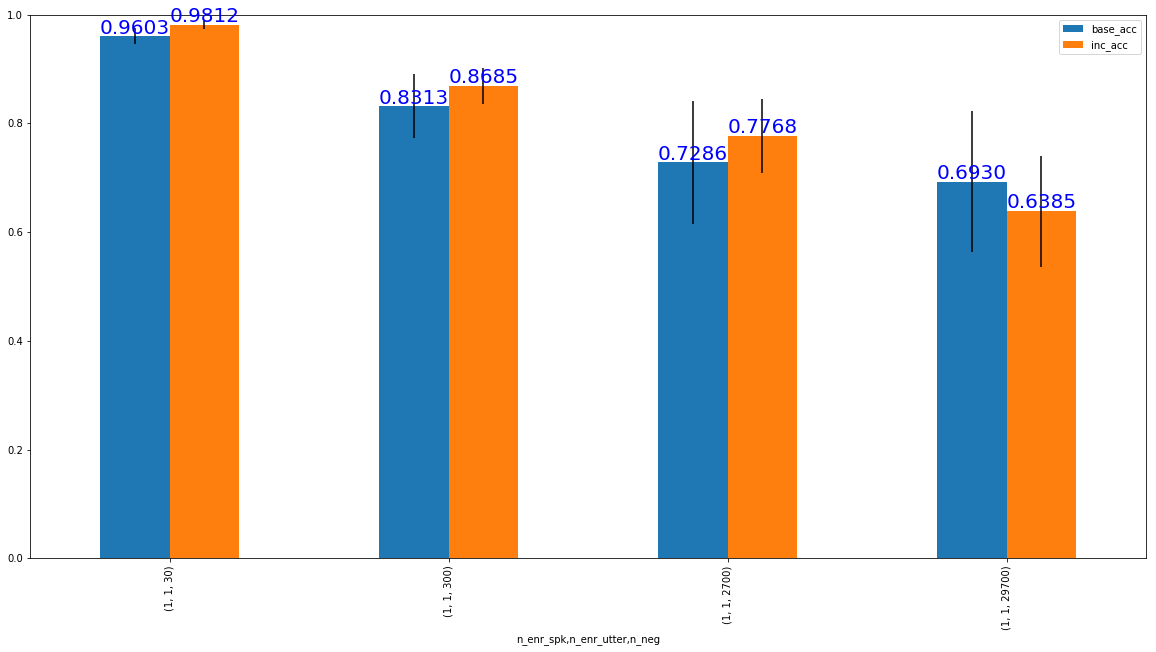

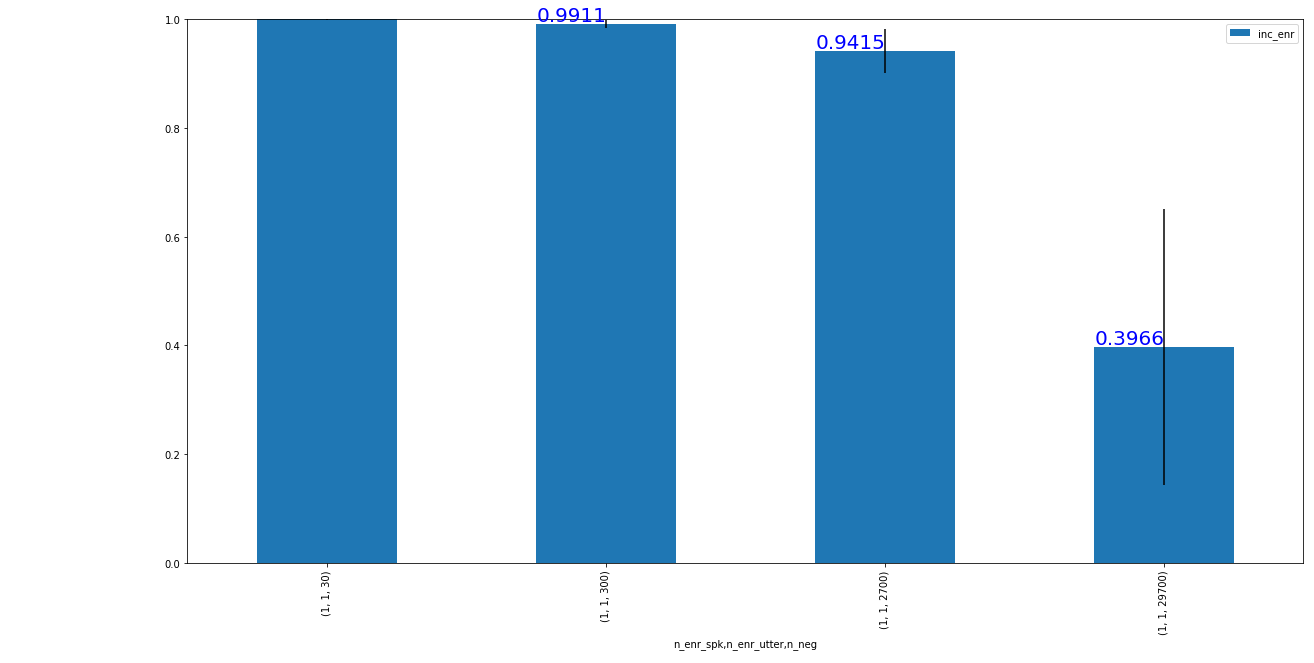

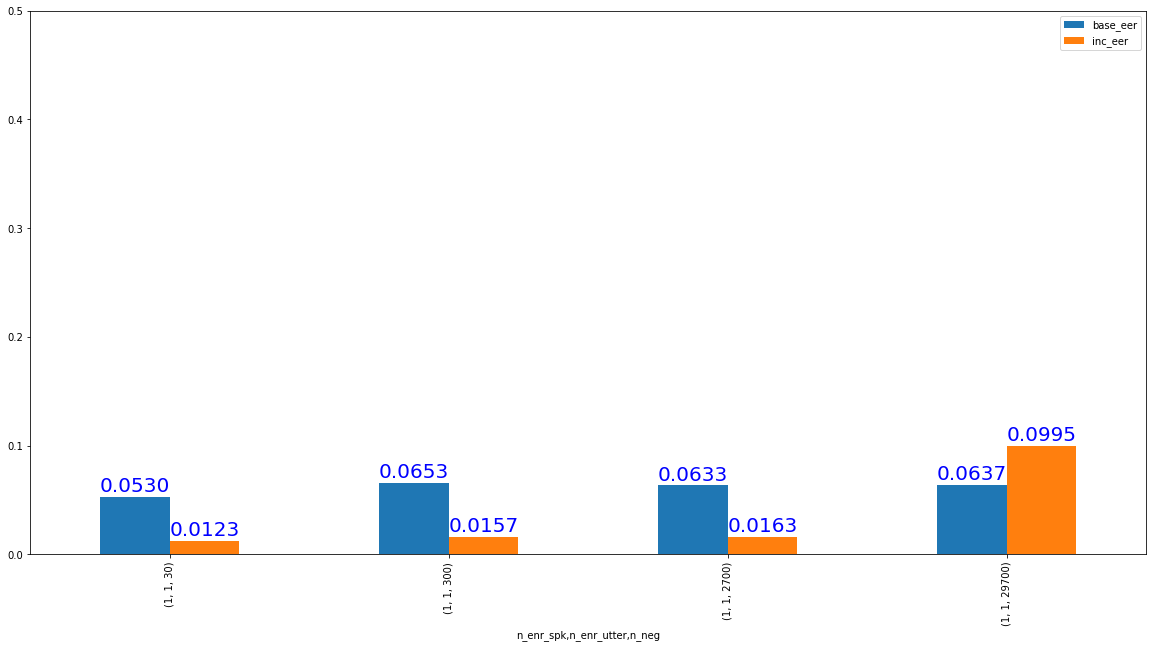

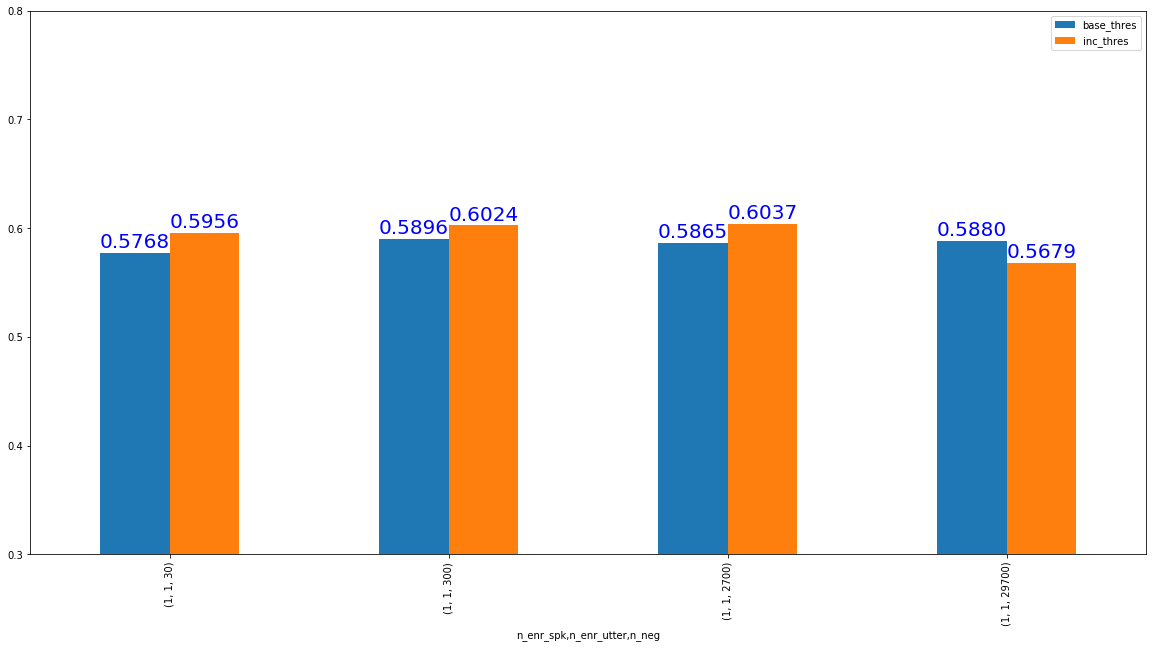

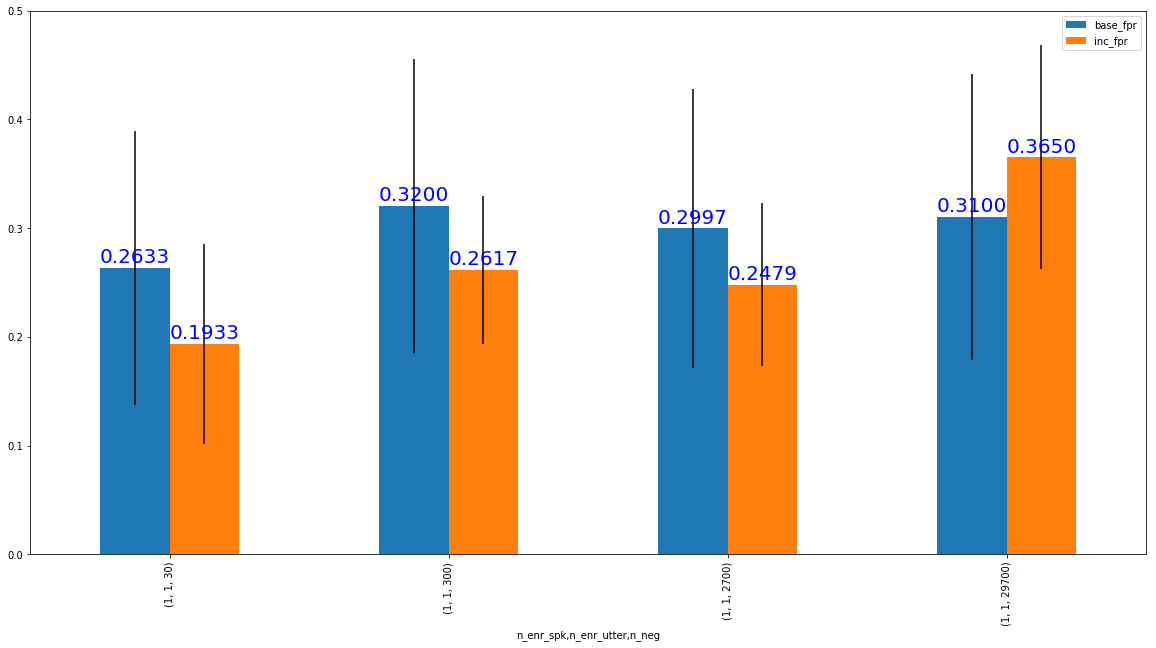

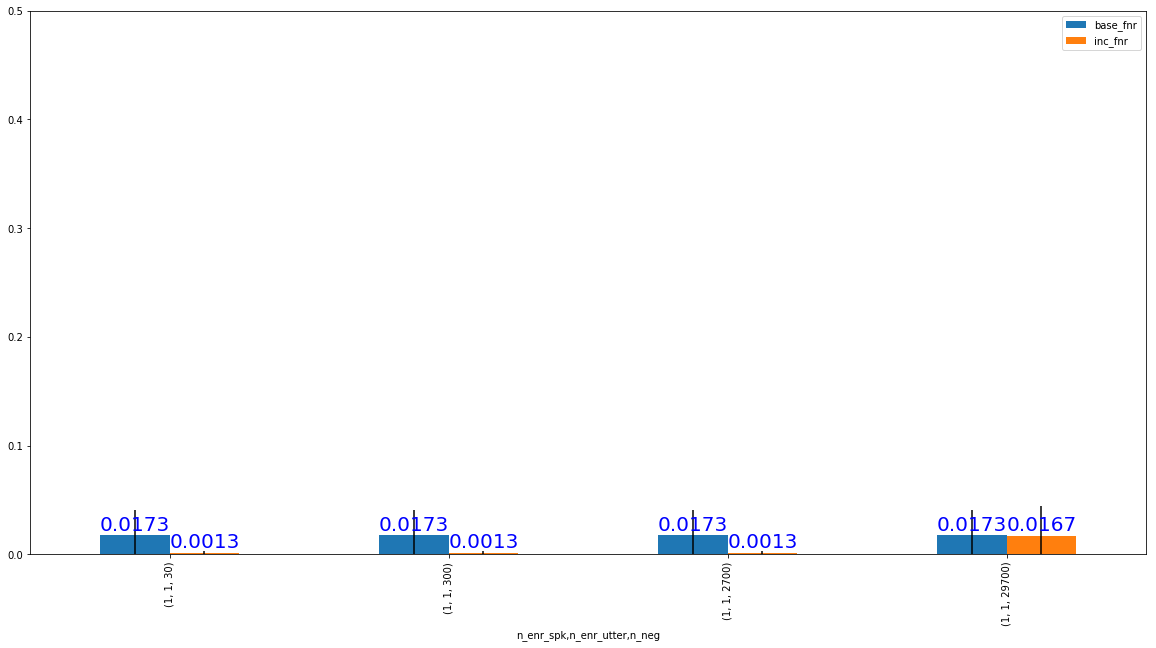

In [1339]:
figsize = (20,10)
figures = []
for graph_type in config['graph_type']:
    default_column = ['n_enr_spk', 'n_enr_utter', 'n_neg']
    if graph_type == 'acc':
        target_column = ['base_acc', 'inc_acc']
        target_ylim = [0.0, 1.0]
    elif graph_type == 'enr':
        target_column = ['inc_enr']
        target_ylim = [0.0, 1.0]
    elif graph_type == 'fpr':
        target_column = ['base_fpr', 'inc_fpr']
        target_ylim = [0.0, 0.5]
    elif graph_type == 'fnr':
        target_column = ['base_fnr', 'inc_fnr']
        target_ylim = [0.0, 0.5]
    elif graph_type == 'eer':
        target_column = ['base_score', 'inc_score', 'label']
        target_ylim = [0.0, 0.5]
    elif graph_type == 'thres':
        target_column = ['base_score', 'inc_score', 'label']
        target_ylim = [0.3, 0.8]
    
    # Filtering and Drawing
    result_df_ = result_df.loc[:, default_column + target_column]
    if graph_type == 'eer':
        apply_eer_df = result_df_.groupby(default_column).apply(compute_trials_eer_wrapper)
        ax_ = apply_eer_df.groupby(default_column).mean().plot.bar(ylim=target_ylim, figsize=figsize, )
    elif graph_type == 'thres':
        apply_thres_df = result_df_.groupby(default_column).apply(compute_trials_thres_wrapper)
        ax_ = apply_thres_df.groupby(default_column).mean().plot.bar(ylim=target_ylim, figsize=figsize, )
    else:
        apply_interval_df = result_df_.groupby(default_column).apply(r2_rmse_interval)
        ax_ = result_df_.groupby(default_column).mean().plot.bar(ylim=target_ylim, figsize=figsize, yerr=apply_interval_df)
    for p in ax_.patches:
        ax_.annotate('{:.4f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.005), color='blue', fontsize='20')
    figures.append(ax_)

In [1340]:
embeds_dir = enroll+'_'+test+'_'+case+'/'
exp_dir = config['sim']
if config['accept_thres_update']:
    exp_dir += '_acceptThresUpdate'
    
if config['enroll_thres_update']:
    exp_dir += '_enrollThresUpdate'

if config['n_use_enroll'] == 'full':
    exp_dir += '_' + config['trial_type'] + '_' + config['n_use_enroll']
else:
    exp_dir += '_' + config['trial_type'] + '_latest' + config['n_use_enroll']
    
    if config['include_init']:
        exp_dir += '[1]'

In [1341]:
v = 0
dir_name = ''
while True:
    dir_name = fig_dir_name + embeds_dir + exp_dir + '_v' + str(v) + '/'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        break
    v += 1
    
with open(dir_name + 'config.txt', 'w') as f:
    f.write(str(config)+'\n')
    # Please add if there is additional information

pickle.dump(enroll_id_sets, open(dir_name+"enroll_id_sets.pkl", "wb"))
pickle.dump(trials_id_sets, open(dir_name+"trials_id_sets.pkl", "wb"))
pickle.dump(trials_label_sets, open(dir_name+"trials_label_sets.pkl", "wb"))
    
result_df.to_pickle(dir_name + 'result_df.pkl')
for i, graph_type in enumerate(config['graph_type']):
    fig_name = graph_type + '.pdf'
    figures[i].get_figure().savefig(dir_name + fig_name, dpi=500)

In [1332]:
#plots = plot_wrapper(result_df[(result_df.n_neg == 360)], 'enroll', 55, 5)

In [1312]:
#for k,v in plots.items():
#    v.savefig(dir_name+k+'_timelines.pdf', dpi=500)